In [11]:
import numpy as np 

def safeDivide(numerator: float, denomonator: float) -> float:
    return 0 if denomonator == 0 else numerator / denomonator

class Results:
    def __init__(self, accuracy:float, mae:float, rmse:float, confusion_matrix:np.ndarray):
        self.accuracy = accuracy
        self.mae = mae
        self.rmse = rmse
        self.true_negatives, self.false_positives, self.false_negatives, self.true_positives = confusion_matrix.ravel()
        self.total = self.true_negatives + self.false_positives + self.false_negatives + self.true_positives
        self.false_positives_rate = self.false_positives / self.total
        self.false_negatives_rate = self.false_negatives / self.total
        self.precision = safeDivide(self.true_positives, (self.true_positives + self.false_positives) )  
        self.recall = safeDivide(self.true_positives, (self.true_positives + self.false_negatives))  
        self.f1_score =  2 * safeDivide((self.precision * self.recall) ,(self.precision + self.recall))

    
    def __str__(self):
        return f'''Results 
    Accuracy: {self.accuracy:.2f}
    Mean Absolute Error: {self.mae:.2f}
    Root Mean Squared Error: {self.rmse:.2f}
    False Positives: {self.false_positives_rate:.2f}
    Fales Negatives: {self.false_negatives_rate: .2f}
    Precision: {self.precision:.2f}
    Recall: {self.recall:.2f}
    F1 Score: {self.f1_score:.2f}'''



In [12]:
import os
import numpy as np 
import pandas as pd 
from  datetime import timedelta, datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score,mean_absolute_error, root_mean_squared_error, confusion_matrix
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt



timestamp = 'timestamp'
unix_timestamp = 'unix_timestamp'
precision = .2

def loadFiles(directory: str) -> list[str]:
    file_paths = np.array([])
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.csv'):
                file_paths = np.append(file_paths, os.path.join(root, file))
    return file_paths

def loadData(file0: str, file1:str) -> tuple[pd.DataFrame, pd.DataFrame]:
    normals = pd.read_csv(file0, encoding='latin-1') 
    anomalies = pd.read_csv(file1, encoding='latin-1') 
    normals['USER'] = 0
    anomalies['USER'] = 1
    normals[unix_timestamp], normals[timestamp] = normals[timestamp], pd.to_datetime(normals[timestamp], unit='ms')
    anomalies[unix_timestamp], anomalies[timestamp] = anomalies[timestamp], pd.to_datetime(anomalies[timestamp], unit='ms')
    print(f'loaded normals: {normals.shape},  loaded anomalies: {anomalies.shape}')
    return normals, anomalies

def random_time_range(anomalies: pd.DataFrame, iteration: int) -> tuple[datetime, datetime]:
    #determine start and end time. subtrat one second from start time to ensure the real start time is always included
    start_time, end_time = anomalies[timestamp].min() - timedelta(seconds=1) , anomalies[timestamp].max()
    print(f'anomalies start_time: {start_time} - end_time: {end_time}')
    
    #pick a random time delta between a range, weighted by the number of iterations
    delta = timedelta(minutes= np.random.randint(5,30) + 2 ** iteration)
    latest_start  = np.maximum(end_time - delta, start_time)
        
    random_start = start_time + timedelta(seconds=np.random.randint(0, int((latest_start - start_time).total_seconds() + 1))) 
    random_end = random_start + delta
    print(f'random time rand selected {random_start} - {random_end}')
    return random_start, random_end

def inject_anomalies(normal:pd.DataFrame, anomalies:pd.DataFrame, start_time: datetime, end_time:datetime) -> tuple[pd.DataFrame, pd.Index]:
    anomalies_condition = (start_time <= anomalies[timestamp]) & (anomalies[timestamp] <= end_time)
    normal_conditoin = (start_time <= normal[timestamp]) & (normal[timestamp] <= end_time)
    #find anomalies that fall within the random time range
    subset_anomalies = anomalies[anomalies_condition]
    index = subset_anomalies.index
    print(f'{subset_anomalies.shape[0]} anomalies selected')

    #if no anomalies found do nothing
    if subset_anomalies.empty:
        return normal, index
    
    #find normals that fall within the same random time range
    subset_normal = normal[normal_conditoin]
    
    #if no normals found append anomalies to normals list
    if subset_normal.empty:
        print('no normal data within range, appending anomalies')
        return pd.concat([normal,subset_anomalies], ignore_index=True), index
    
    #if normals found remove them and append anomalies to list to prevent unrealistic data where 2 users are interating with 1 machine
    print(f'{subset_normal.shape[0]} normals selected to be overwritten')
    return pd.concat([normal.drop(normal[normal_conditoin].index), subset_anomalies], ignore_index=True), index  

def mergeData(normals:pd.DataFrame, anomalies:pd.DataFrame, anomaly_percentage_target:float=0.05) -> tuple[pd.DataFrame,float]:
    max_size = normals.shape[0] + anomalies.shape[0]
    anomaly_percentage = 0
    iteration = 0
    #merge two datasets
    while anomaly_percentage < anomaly_percentage_target and normals.shape[0] < max_size and not anomalies.empty:
        iteration+=1
        print(f'current iteration: {iteration} - anomaly_size: {anomalies.shape} - anomaly_percentage: {anomaly_percentage} - current_size: {normals.shape[0]} -  max_size: {max_size}')
        print(f'starting shape: {normals.shape}')
        normals, index = inject_anomalies(normals, anomalies, *random_time_range(anomalies, iteration))
        anomalies.drop(index, inplace=True)
        print(f'ending shape: {normals.shape}')
        anomaly_percentage = normals[normals['USER'] == 1].shape[0] / normals.shape[0]

    print(f'total iterations: {iteration} - final anomaly_percentage: {anomaly_percentage}')
    normals.sort_values(timestamp)
    print(f'merged shape: {normals.shape}')
    return normals, anomaly_percentage

def reduceDimensions(data: pd.DataFrame) -> pd.DataFrame:
    columns_to_drop = [
        timestamp,
        'active_apps_average',
        'current_app',
        'penultimate_app',
        'changes_between_apps',
        'current_app_foreground_time',
        'current_app_average_processes',
        'current_app_stddev_processes',
        'current_app_average_cpu',
        'current_app_stddev_cpu',
        'system_average_cpu',
        'system_stddev_cpu',
        'current_app_average_mem',
        'current_app_stddev_mem',
        'system_average_mem',
        'system_stddev_mem',
        'received_bytes',
        'sent_bytes'
    ]
    return data.iloc[:, ~data.columns.isin(columns_to_drop)]
      
def normalizeAndSplitData(data: pd.DataFrame, train_size: float = 0.70, test_size: float = 0.15, validate_size: float = 0.15, look_back: int = 0, batch_size: int = 128) -> tuple[TimeseriesGenerator,TimeseriesGenerator,TimeseriesGenerator]:
    user_mask = data.columns.isin(['USER'])
    features = data.iloc[:, ~user_mask].to_numpy()
    labels = data.iloc[:, user_mask].to_numpy()
    
    #normalizing data 
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    #split data
    non_train_size = test_size + validate_size
    features_train, features_temp, labels_train, labels_temp = train_test_split(features_scaled,labels, train_size=train_size, test_size= non_train_size, shuffle=False, random_state=42) 

    # Split the temporary data into 50% validation and 50% test (50% of 30% is 15% each)
    features_validation, features_test, labels_validation, labels_test = train_test_split(features_temp, labels_temp, train_size= validate_size / non_train_size, test_size=test_size / non_train_size, shuffle=False, random_state=42)
    
    train_generator = TimeseriesGenerator(features_train, labels_train, length=look_back, batch_size=batch_size)
    test_generator = TimeseriesGenerator(features_test, labels_test, length=look_back, batch_size=batch_size)
    validation_generator = TimeseriesGenerator(features_validation, labels_validation, length=look_back, batch_size=batch_size)
    return train_generator, test_generator, validation_generator 

def buildTrainAndTestModel(train: TimeseriesGenerator, test:TimeseriesGenerator, epochs:int, look_back:int=0):
    model = Sequential()
    features_count = train.data.shape[1]
    model.add(LSTM(50, activation='relu', input_shape=(look_back,features_count )))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    history = model.fit(train, epochs=epochs, verbose=1, validation_data=test)
    return model, history  

def validateModel(model: Sequential, validation: TimeseriesGenerator, look_back:int=0) -> Results:
    # Make a prediction (example with last batch of validation data)
    predictions = model.predict(validation)
    predictions = (predictions >= 0.5).astype(int)
    actual = validation.targets[look_back:]

    # Calculate accuracy, MAE and RMSE
    accuracy = accuracy_score(actual, predictions)
    mae = mean_absolute_error(actual, predictions)
    rmse = root_mean_squared_error(actual, predictions)
    cm = confusion_matrix(actual, predictions)
    results = Results(accuracy,mae,rmse,cm)
    print(results)
    return results


def plotHistory(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history['loss'], label='Training Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plotMetrics(metrics: list):
    for metric in metrics:
        plotHistory(metric['history'])

changed working dir to: /Users/osono/Library/CloudStorage/OneDrive-NorthCarolinaA&TStateUniversity/COMP 850 - 1A Big Data Analytics/Project/continuous authentication/datasets/Behacom
loaded normals: (55778, 12052),  loaded anomalies: (15358, 12052)
current iteration: 1 - anomaly_size: (15358, 12052) - anomaly_percentage: 0 - current_size: 55778 -  max_size: 71136
starting shape: (55778, 12052)
anomalies start_time: 2019-11-20 10:20:29.186000 - end_time: 2020-01-14 09:54:29.879000
random time rand selected 2019-12-29 20:32:04.186000 - 2019-12-29 21:02:04.186000
0 anomalies selected
ending shape: (55778, 12052)
current iteration: 2 - anomaly_size: (15358, 12052) - anomaly_percentage: 0.0 - current_size: 55778 -  max_size: 71136
starting shape: (55778, 12052)
anomalies start_time: 2019-11-20 10:20:29.186000 - end_time: 2020-01-14 09:54:29.879000
random time rand selected 2020-01-09 03:27:04.186000 - 2020-01-09 03:48:04.186000
0 anomalies selected
ending shape: (55778, 12052)
current itera

/opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 50)             │     2,416,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,416,851 (9.22 MB)

 Trainable params: 2,416,851 (9.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
  13/2736 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - accuracy: 0.7002 - loss: 0.6414   

/opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2736/2736 ━━━━━━━━━━━━━━━━━━━━ 37s 13ms/step - accuracy: 0.9900 - loss: 0.4110 - val_accuracy: 0.5817 - val_loss: 205.0044
Epoch 2/5
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 35s 13ms/step - accuracy: 1.0000 - loss: 2.0908e-05 - val_accuracy: 0.5785 - val_loss: 205.5022
Epoch 3/5
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 34s 12ms/step - accuracy: 1.0000 - loss: 6.6314e-06 - val_accuracy: 0.5785 - val_loss: 205.5388
Epoch 4/5
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 36s 13ms/step - accuracy: 1.0000 - loss: 2.3521e-06 - val_accuracy: 0.5785 - val_loss: 205.6281
Epoch 5/5
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 36s 13ms/step - accuracy: 1.0000 - loss: 1.3744e-08 - val_accuracy: 0.5780 - val_loss: 206.2310
586/586 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Accuracy: 1.00
    Mean Absolute Error: 0.00
    Root Mean Squared Error: 0.02
    False Positives: 0.00
    Fales Negatives:  0.00
    Precision: 0.00
    Recall: 0.00
    F1 Score: 0.00


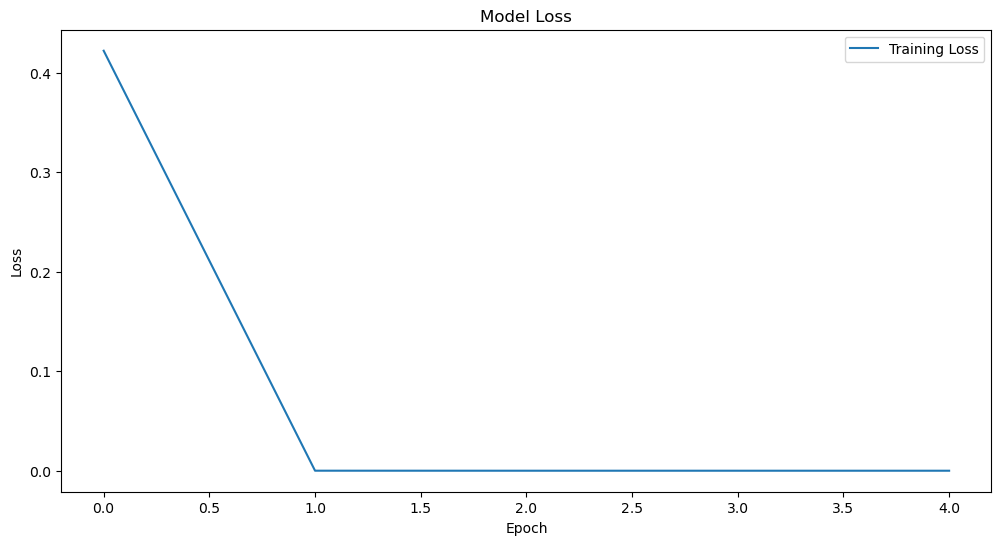

In [13]:
working_dir = '/Users/osono/Library/CloudStorage/OneDrive-NorthCarolinaA&TStateUniversity/COMP 850 - 1A Big Data Analytics/Project/continuous authentication/datasets/Behacom'
os.chdir(working_dir)
current_directory = os.getcwd()
print(f'changed working dir to: {current_directory}')

look_back = 3
epochs = 5
file_paths = loadFiles(current_directory)

metrics = []
while file_paths.size > 0 and len(metrics) < 1:
    choices =  np.random.choice(file_paths, size=2, replace=False)
    file_paths = file_paths[np.isin(file_paths, choices, invert=True)]
    normals, anomalies = loadData(choices[0], choices[1])
    metric = {
        'normals': {
            'path': choices[0],
            'shape': normals.shape
        },
        'anomalies': {
            'path': choices[1],
            'shape': anomalies.shape
        }
    }
    merged, anomaly_percentage = mergeData(normals, anomalies)
    merged = reduceDimensions(merged)
    metric['merged'] = {
        'shape': merged.shape,
        'anomaly_percentage': anomaly_percentage
    }
    
    train, test, validation = normalizeAndSplitData(merged, look_back=look_back, batch_size=10)
    model, history = buildTrainAndTestModel(train, test, epochs=epochs, look_back=look_back)
    metric['history'] = history.history
    results = validateModel(model,validation,look_back=look_back)
    metric['results'] = results
    metrics.append(metric)

plotMetrics(metrics)    